In [1]:
import pandas as pd
import geocoder
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import normaltest
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_white,het_breuschpagan

#  ТЕКСТОВЫЙ АНАЛИЗ НА РЫНКЕ НЕДВИЖИМОСТИ
## Проектная работа по предмету количественные методы в экономике 
### Выполнили: Гончаров Глеб, Егоров Владимир
### Основано на "TEXTUAL ANALYSIS IN REAL ESTATE"
by ADAM NOWAK AND PATRICK SMITH

### Работе рассматриваются три модели
<center>1. Базовая</center>
$$ p_it=(z_it,a_1 )+(v_i,a_2 )+ε_i$$
<center>2. Модель с униграммами</center>
$$ p_it=(z_it,a_1 )+(v_i,a_2 )+ε_i$$
<center>3. Модель с биграммами</center>
$$ p_it=(z_it,a_1 )+(w_i,a_2 )+ε_i$$

In [2]:
def adj_r2_score(y_true, y_pred, n):
    return 1 - (1 - r2_score(y_true, y_pred)) * (y_true.shape[0] - 1 )/ ( y_true.shape[0] - n - 1)
def return_words(vectorizer, regresor, n):
    params = np.array(regresor.params[3:])
    good_ind = params.argsort()[-n:]
    bad_ind = params.argsort()[:n]
    good, bad = [],[]
    
    for i in good_ind:
        for key, value in vectorizer.vocabulary_.items():
            if value == i:
                good.append(key)
    for i in bad_ind:
        for key, value in vectorizer.vocabulary_.items():
            if value == i:
                bad.append(key)
    return good, bad

# I. Обработка первончальных данных, описательная статистика

### Вид первончальных данных

In [3]:
#Initail datased (parsed cian)
df = pd.read_csv('odi_cian.csv')
df.head()

advAddress  \
0  Московская область, Одинцово, мкр. 4, ул. Ново...   
1  Московская область, Одинцово, ул. Сколковская, 3А   
2   Московская область, Одинцово, ул. Гвардейская, 9   
3    Московская область, Одинцово, Северная ул., 5к3   
4  Московская область, Одинцово, мкр. 7, 7-й микр...   

                                        metro      price  \
0                                           -  6 950 000   
1                                           -  4 485 000   
2          Молодежная, Крылатское, Кунцевская  5 450 000   
3  Славянский бульвар, Кунцевская, Молодежная  5 700 000   
4              Кунцевская, Славянский бульвар  2 402 000   

                   advName                                        description  
0  4-комн. квартира, 65 м²  Продается 4-х комнатная квартира! г. Одинцово,...  
1  1-комн. квартира, 38 м²  Сколковский.ПЕРЕУСТУПКА от Собственника!!!  Де...  
2  1-комн. квартира, 39 м²  Проедается новая квартира с качественной дизай...  
3  1-комн. квартира, 32 м²  ЖК Одинбург! Квартира только после ремонта и у...  
4          Студия, 25,4 м²  Продается квартира-студия площадью 25,4 кв.м н...

### Из поля advName взяли количество комнат и квадратных метров, добавили дами-переменные для станций метро

In [4]:
#Added rooms and sq param
df['rooms'] = df['advName'].apply(lambda x: int(x[0]) if str.isdigit(x[0]) else 1)
df['sq'] = df['advName'].apply(lambda x: int(x.split(',')[-1].split(' ')[1]) 
                                if x.split(',')[-1].split(' ')[1] != 'м²' 
                                 else int(x.split(',')[-2].split(' ')[1]))
df.drop('advName',axis=1,inplace=True)
#Added dummies for subway stations
metr = []
for s in df['metro'].unique()[1:]:
    for j in s.split(','):
        if j.strip() not in metr:
            metr.append(j.strip())
for m in metr:
    df[m] = df['metro'].apply(lambda x : 1 if m in x else 0)
df.drop('metro',inplace=True,axis=1)

In [5]:
df.head()

advAddress      price  \
0  Московская область, Одинцово, мкр. 4, ул. Ново...  6 950 000   
1  Московская область, Одинцово, ул. Сколковская, 3А  4 485 000   
2   Московская область, Одинцово, ул. Гвардейская, 9  5 450 000   
3    Московская область, Одинцово, Северная ул., 5к3  5 700 000   
4  Московская область, Одинцово, мкр. 7, 7-й микр...  2 402 000   

                                         description  rooms  sq  Молодежная  \
0  Продается 4-х комнатная квартира! г. Одинцово,...      4  65           0   
1  Сколковский.ПЕРЕУСТУПКА от Собственника!!!  Де...      1  38           0   
2  Проедается новая квартира с качественной дизай...      1  39           1   
3  ЖК Одинбург! Квартира только после ремонта и у...      1  32           1   
4  Продается квартира-студия площадью 25,4 кв.м н...      1  25           0   

   Крылатское  Кунцевская  Славянский бульвар  Киевская     ...      \
0           0           0                   0         0     ...       
1           0           0                   0         0     ...       
2           1           1                   0         0     ...       
3           0           1                   1         0     ...       
4           0           1                   1         0     ...       

   Боровское шоссе  Солнцево  Деловой центр  Беговая  Белорусская  Говорово  \
0                0         0              0        0            0         0   
1                0         0              0        0            0         0   
2                0         0              0        0            0         0   
3                0         0              0        0            0         0   
4                0         0              0        0            0         0   

   Филевский парк  Тропарево  Саларьево  Пионерская  
0               0          0          0           0  
1               0          0          0           0  
2               0          0          0           0  
3               0          0          0           0  
4               0          0          0           0  

[5 rows x 26 columns]

### Перевели адреса в координаты

In [7]:
#Executes about 8 minutes
latlng = [] 
for s in df['advAddress']:
    latlng.append(geocoder.yandex(s).latlng)
df.drop('advAddress',axis=1,inplace=True)
latlng = np.array(latlng)
df['lat'] = latlng[:,0]
df['lon'] = latlng[:,1]
df.head()
col = ['price','rooms', 'sq','lat', 'lon','description', 'Молодежная', 'Крылатское',
       'Кунцевская', 'Славянский бульвар', 'Киевская', 'Парк Победы',
       'Юго-Западная', 'Новопеределкино', 'Фили', 'Рассказовка', 'Кутузовская',
       'Боровское шоссе', 'Солнцево', 'Деловой центр', 'Беговая',
       'Белорусская', 'Говорово', 'Филевский парк', 'Тропарево', 'Саларьево',
       'Пионерская']
df = df.reindex(columns=col)
df.to_csv('odi_latlon.csv',index=False)

KeyboardInterrupt: 

In [8]:
df = pd.read_csv('odi_latlon.csv')
df.head()

price  rooms  sq        lat        lon  \
0  6 950 000      4  65  55.683686  37.284908   
1  4 485 000      1  38  55.696357  37.322934   
2  5 450 000      1  39  55.655249  37.231378   
3  5 700 000      1  32  55.681047  37.245751   
4  2 402 000      1  25  55.677905  37.287873   

                                         description  Молодежная  Крылатское  \
0  Продается 4-х комнатная квартира! г. Одинцово,...           0           0   
1  Сколковский.ПЕРЕУСТУПКА от Собственника!!!  Де...           0           0   
2  Проедается новая квартира с качественной дизай...           1           1   
3  ЖК Одинбург! Квартира только после ремонта и у...           1           0   
4  Продается квартира-студия площадью 25,4 кв.м н...           0           0   

   Кунцевская  Славянский бульвар     ...      Боровское шоссе  Солнцево  \
0           0                   0     ...                    0         0   
1           0                   0     ...                    0         0   
2           1                   0     ...                    0         0   
3           1                   1     ...                    0         0   
4           1                   1     ...                    0         0   

   Деловой центр  Беговая  Белорусская  Говорово  Филевский парк  Тропарево  \
0              0        0            0         0               0          0   
1              0        0            0         0               0          0   
2              0        0            0         0               0          0   
3              0        0            0         0               0          0   
4              0        0            0         0               0          0   

   Саларьево  Пионерская  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0  

[5 rows x 27 columns]

### Мы поняли, что добавлять каждую станцию метро - это не оч хорошая идея, потому что они "идут" вместе. Объеденили станции в три группы: желтая и красная - по цвету веток, остальные - отдельная группа. Получили вид итогового датасета.

In [ ]:
#To add subways isn't really good idea, so we united them in groups
railway = ['Молодежная', "Крылатское", "Кунцевская", "Славянский бульвар", "Киевская","Парк Победы","Фили", "Кутузовская","Деловой центр", "Филевский парк", "Пионерская","Беговая", "Белорусская"]
red = ["Юго-Западная", "Тропарево","Саларьево"]
yellow =["Новопеределкино","Рассказовка", "Боровское шоссе", "Солнцево","Говорово"]
col = df['Молодежная'].copy()
for i in railway[1:]:
    col += df[i]
df['railway'] = col.apply(lambda x: 1 if x >= 1 else 0)
col = df['Юго-Западная'].copy()
for i in red[1:]:
    col += df[i]
df['red'] = col.apply(lambda x: 1 if x >= 1 else 0)
col = df['Новопеределкино'].copy()
for i in yellow[1:]:
    col += df[i]
df['yellow'] = col.apply(lambda x: 1 if x >= 1 else 0)
df.drop(railway,axis=1,inplace=True)
df.drop(red,axis=1,inplace=True)
df.drop(yellow,axis=1,inplace=True)
df['price'] = df['price'].apply(lambda x: x.replace(' ',''))
df['price'].astype('int64')
df['description'] = df['description'].apply(lambda x: str.lower(x))
df.head()
df.to_csv('odi_final.csv',index=False)

In [9]:
df = pd.read_csv('odi_final.csv')
df.head()

price  rooms  sq        lat        lon  \
0  6950000      4  65  55.683686  37.284908   
1  4485000      1  38  55.696357  37.322934   
2  5450000      1  39  55.655249  37.231378   
3  5700000      1  32  55.681047  37.245751   
4  2402000      1  25  55.677905  37.287873   

                                         description  railway  red  yellow  
0  продается 4-х комнатная квартира! г. одинцово,...        0    0       0  
1  сколковский.переуступка от собственника!!!  де...        0    0       0  
2  проедается новая квартира с качественной дизай...        1    0       0  
3  жк одинбург! квартира только после ремонта и у...        1    0       0  
4  продается квартира-студия площадью 25,4 кв.м н...        1    0       0

### Корреляция между квадратными метрами и количеством комнта сильная - убираем количество комнат из модели. 

In [10]:
df.corr()

price     rooms        sq       lat       lon   railway       red  \
price    1.000000  0.610630  0.823488  0.033051  0.057811 -0.068953 -0.081625   
rooms    0.610630  1.000000  0.820306  0.027184  0.005037 -0.044604 -0.043580   
sq       0.823488  0.820306  1.000000  0.023177  0.035656 -0.009463 -0.064793   
lat      0.033051  0.027184  0.023177  1.000000  0.741241 -0.010806 -0.131368   
lon      0.057811  0.005037  0.035656  0.741241  1.000000 -0.004548 -0.138533   
railway -0.068953 -0.044604 -0.009463 -0.010806 -0.004548  1.000000  0.149773   
red     -0.081625 -0.043580 -0.064793 -0.131368 -0.138533  0.149773  1.000000   
yellow  -0.020665  0.017983 -0.012960 -0.005670 -0.051824 -0.173609 -0.036145   

           yellow  
price   -0.020665  
rooms    0.017983  
sq      -0.012960  
lat     -0.005670  
lon     -0.051824  
railway -0.173609  
red     -0.036145  
yellow   1.000000

In [11]:
df.describe()

price        rooms           sq          lat          lon  \
count  1.497000e+03  1497.000000  1497.000000  1497.000000  1497.000000   
mean   7.173949e+06     1.937876    60.323981    55.680439    37.285373   
std    4.204186e+06     0.886328    25.325552     0.015960     0.031733   
min    2.170011e+06     1.000000    18.000000    55.652557    37.227129   
25%    4.970000e+06     1.000000    42.000000    55.664822    37.258615   
50%    6.126820e+06     2.000000    57.000000    55.681981    37.289562   
75%    8.000000e+06     3.000000    72.000000    55.694758    37.319161   
max    5.600000e+07     5.000000   249.000000    55.707415    37.333265   

           railway          red       yellow  
count  1497.000000  1497.000000  1497.000000  
mean      0.566466     0.031396     0.038744  
std       0.495728     0.174444     0.193049  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       1.000000     0.000000     0.000000  
75%       1.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000

### Объявление с максимальной ценой

In [12]:
df[df['price'] == df['price'].max()].T

1409
price                                                 56000000
rooms                                                        4
sq                                                         249
lat                                                    55.6526
lon                                                     37.244
description  лот: 0500477. квартира под отделку 250 кв.м на...
railway                                                      1
red                                                          0
yellow                                                       0

## II. Model #1. Simple Linear Regression

In [13]:
df.drop('rooms',axis=1,inplace=True)
X_train, X_test, Y_train, Y_test  = train_test_split(df.drop(['price'], axis=1),
                                                     np.log(df['price']), test_size=0.2, random_state=3)
lr = sm.OLS(Y_train,X_train.drop(['description'],axis=1)).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.343e+06
Date:                Thu, 30 May 2019   Prob (F-statistic):               0.00
Time:                        14:56:10   Log-Likelihood:                 284.13
No. Observations:                1197   AIC:                            -556.3
Df Residuals:                    1191   BIC:                            -525.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sq             0.0135      0.000     61.535      0.0

### R2 и Adjusted R2

In [14]:
print('In sample r2:',adj_r2_score(Y_train,lr.predict(X_train.drop('description',axis=1)),X_train.shape[1] - 1), 
      'Out of sample r2:',adj_r2_score(Y_test,lr.predict(X_test.drop('description',axis=1)),X_train.shape[1]))

In sample r2: 0.7687854294881439 Out of sample r2: 0.7385740295124328


### Проверка предпосылок теоремы Гаусса-Маркова
1. Равенство матожидания 0

In [15]:
eps = Y_train - lr.predict(X_train.drop('description',axis=1))
print('Residuals mean:', eps.mean())

Residuals mean: -3.0051958806700314e-06


2. Независимость остатков и переменных видна из графика

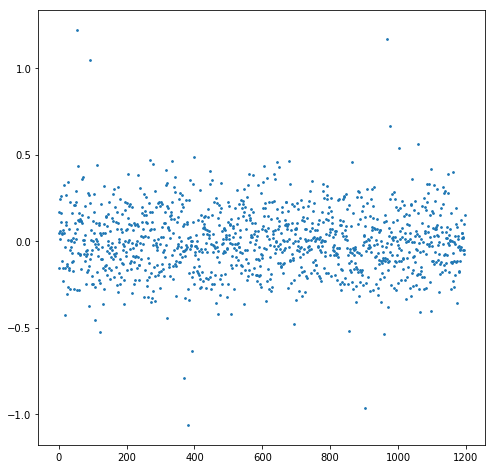

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(range(len(eps)),eps,s=3);

3. Согласно тесту условие гетероскедастичности не выполняется

In [17]:
p_value = het_breuschpagan(eps,lr.model.exog)[-1]
print('P-value:', p_value)

P-value: 3.099797766677566e-52


4. Не понимаем, как проверить ковариации остатков

### Проверка нормальности распредления остатков
Из теста на нормальность, как и из графика видно, что остатки не распределны нормально

P-value: 1.5137330946725402e-31 
p-value почти ноль - отклоняем нулевую гипотезу, поэтому распредление остатков не является нормальным


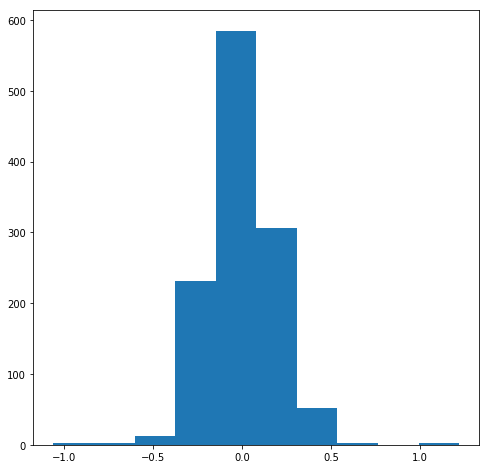

In [18]:
plt.figure(figsize=(8,8))
plt.hist(eps)
print('P-value:', normaltest(eps)[-1], '\np-value почти ноль - отклоняем нулевую гипотезу, поэтому распредление остатков не является нормальным')

## Model #2. Linear Regression with Unigrams

In [19]:
stop_words = stopwords.words('russian')
vectorizer_uni = CountVectorizer(min_df=120,stop_words=stop_words)
train_uni_descr = vectorizer_uni.fit_transform(X_train['description'])
test_uni_descr = vectorizer_uni.transform(X_test['description'])
train_uni_descr.shape

(1197, 140)

In [20]:
X_train_unigram = np.hstack([X_train[['sq','lat','lon']], train_uni_descr.toarray()])
X_test_unigram = np.hstack([X_test[['sq','lat','lon']], test_uni_descr.toarray()])
X_train_unigram.shape

(1197, 143)

In [21]:
X_test_unigram[0,:]

array([59.      , 55.697904, 37.320158,  0.      ,  0.      ,  1.      ,
        0.      ,  2.      ,  0.      ,  3.      ,  0.      ,  2.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  1.      ,  0.      ,
        0.      ,  2.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  1.      ,  0.      ,  2.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  3.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  1.      ,  2.      ,
        2.      ,  1.      ,  0.      ,  1.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  1.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  1.      ,  0.      ,  0.      ,
        1.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  2.      ,  0.      ,  1.      ,  1.      ,  1.      ,
        1.      ,  0.      ,  1.      ,  0.      , 

In [22]:
lr_uni = sm.OLS(Y_train,X_train_unigram).fit()
print(lr_uni.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.390e+04
Date:                Thu, 30 May 2019   Prob (F-statistic):               0.00
Time:                        14:56:48   Log-Likelihood:                 595.72
No. Observations:                1197   AIC:                            -905.4
Df Residuals:                    1054   BIC:                            -177.9
Df Model:                         143                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0129      0.000     60.564      0.0

### R2 и Adjusted R2

In [23]:
print('In sample r2:',adj_r2_score(Y_train,lr_uni.predict(X_train_unigram),X_train.shape[1]), 
      'Out of sample r2:',adj_r2_score(Y_test,lr_uni.predict(X_test_unigram),X_train.shape[1]))

In sample r2: 0.8625067156323412 Out of sample r2: 0.7926274842323343


In [24]:
good_uni, bad_uni = return_words(vectorizer_uni, lr_uni,20)
print('Good ones:\n', good_uni)
print('Bad ones:\n',bad_uni)

Good ones:
 ['квартире', 'кухня', 'остановка', 'комфортной', 'юго', 'территория', 'техникой', 'жизни', 'паркинг', 'города', 'победы', 'фитнес', 'площадки', 'мебель', 'ремонтом', 'доступности', 'общей', 'класса', 'материалов', 'up']
Bad ones:
 ['сколковский', 'огороженная', 'это', 'жилой', 'шаговой', 'спортивные', 'пешей', 'отделки', 'западная', 'остается', 'квартал', 'готовы', 'сады', 'сад', 'площадью', 'комната', 'проекта', 'аптеки', 'лет', 'жк']


<div style='float:left'><img width=400 src="1.png" alt="HSE logo"></img></div> 
<div style='float:right'><img width=400 src="2.png" alt="HSE logo"></img></div> 



## Model #3. Linear Regression with Bigrams

In [25]:
vectorizer_bi = CountVectorizer(min_df=76,stop_words=stop_words,ngram_range=(2,2))
train_bi_descr = vectorizer_bi.fit_transform(X_train['description'])
test_bi_descr = vectorizer_bi.transform(X_test['description'])
train_bi_descr.shape

(1197, 137)

In [26]:
X_train_bigram = np.hstack([X_train[['sq','lat','lon']], train_bi_descr.toarray()])
X_test_bigram = np.hstack([X_test[['sq','lat','lon']], test_bi_descr.toarray()])
X_train_bigram.shape

(1197, 140)

In [27]:
lr_bi = sm.OLS(Y_train,X_train_bigram).fit()
print(lr_bi.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.002e+05
Date:                Thu, 30 May 2019   Prob (F-statistic):               0.00
Time:                        14:56:52   Log-Likelihood:                 416.69
No. Observations:                1197   AIC:                            -647.4
Df Residuals:                    1104   BIC:                            -174.2
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0132      0.000     58.641      0.0

In [28]:
print('In sample r2:',adj_r2_score(Y_train,lr_bi.predict(X_train_bigram),X_train.shape[1]), 
      'Out of sample r2:',adj_r2_score(Y_test,lr_bi.predict(X_test_bigram),X_train.shape[1]))

In sample r2: 0.8145649550489513 Out of sample r2: 0.7242669198096012


In [29]:
good_bi, bad_bi = return_words(vectorizer_bi, lr_bi,20)
print('Good ones:\n', good_bi)
print('Bad ones:\n', bad_bi)

Good ones:
 ['выход сделку', '10 млн', 'общей площадью', 'безопасность сделки', 'минскому шоссе', 'сколковский престижном', 'бизнес класса', 'многое другое', 'отделочных материалов', 'комфортной жизни', 'новый up', 'пол потолок', 'предчистовой отделкой', 'продаётся квартира', 'квартал сколковский', 'монолитных корпусов', 'оригинальной архитектуры', '25 этажей', 'архитектуры 17', '25 га']
Bad ones:
 ['13 монолитных', 'корпусов переменной', 'черновые работы', 'up квартал', 'стены полностью', 'квартиры позволяет', 'одинцово входит', 'районе это', 'этажей огороженная', 'это дома', 'дома оригинальной', 'разводка электрики', '17 25', 'школа многое', 'другое вашей', 'вашей комфортной', 'гусарская баллада', 'сделки рамках', 'свободная планировка', 'сада школа']


<div style='float:left'><img width=400 src="3.png" alt="HSE logo"></img></div> 
<div style='float:right'><img width=400 src="4.png" alt="HSE logo"></img></div> 
